# Создание графа знаний при помощи эмбеддера через косинусное сходство чанков

В данном примере я попытался воплотить в жизнь одну простую идею, суть её в следующем:

- берём некий большой текстовый документ
- нарезаем его на семантические близкие друг к другу чанки
- далее из всех чанков извлекаем векторы признаков
- через косинусное сходство строим связи между нодами

Структура JSON у графа будет следующая:

```json
{
  "nodes": [
    {"id": 0, "name": "текст 1"},
    {"id": 1, "name": "текст 1"},
    ...
    {"id": N, "name": "текст 1"},
  ],
  "links": [
    {"source": 1, "target": 2, "weight": 0.12},
    {"source": 2, "target": 3, "weight": 0.23},
    ...
    {"source": N, "target": M, "weight": 0.123},
  ]
}
```

Прочтём большой текстовый документ, в данном случае Конституция Российской Федерации.

In [20]:
file_path = 'constitutionrf.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

При помощи семантической нарезки доступной в пакете LangChain разделим большой текст на множество логически связанных чанков (персентиль 0.5)

In [21]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain.embeddings import HuggingFaceEmbeddings

text_embedder = HuggingFaceEmbeddings(model_name='intfloat/multilingual-e5-large')
text_splitter = SemanticChunker(text_embedder, breakpoint_threshold_type="percentile", breakpoint_threshold_amount=50)

chunks = text_splitter.create_documents([text])

print(f"Всего чанков: {len(chunks)}")
print("Первые N чанков:")
chunks[:10]

Всего чанков: 474
Первые N чанков:


[Document(page_content='\ufeffКОНСТИТУЦИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ\n\n\nМы, многонациональный народ Российской Федерации,\nсоединенные общей судьбой на своей земле,\nутверждая права и свободы человека, гражданский мир и согласие,\nсохраняя исторически сложившееся государственное единство,\nисходя из общепризнанных принципов равноправия и самоопределения народов,\nчтя память предков, передавших нам любовь и уважение к Отечеству, веру в добро и справедливость,\nвозрождая суверенную государственность России и утверждая незыблемость ее демократической основы,\nстремясь обеспечить благополучие и процветание России,\nисходя из ответственности за свою Родину перед нынешним и будущими поколениями,\nсознавая себя частью мирового сообщества,\nпринимаем КОНСТИТУЦИЮ РОССИЙСКОЙ ФЕДЕРАЦИИ. РАЗДЕЛ ПЕРВЫЙ\n\nГЛАВА 1.'),
 Document(page_content='ОСНОВЫ КОНСТИТУЦИОННОГО СТРОЯ\n\nСтатья 1\n\n1. Российская Федерация - Россия есть демократическое федеративное правовое государство с республиканской формой правле

Через модель-эмбеддер конвертируем полученные чанки в эмбеддинги.

In [22]:
texts = [chunk.page_content for chunk in chunks]
embeddings = text_embedder.embed_documents(texts)

Проанализируем все эмбеддинги через косинусное сходство, отбивка по 0.9, всё что ниже не воспринимаем как связь.

In [23]:
from scipy import spatial

similarity_matrix = []
for i in range(len(chunks)):
    row = []
    for j in range(len(chunks)):
        if i != j:
            similarity = 1 - spatial.distance.cosine(embeddings[i], embeddings[j])
            row.append(similarity)
    similarity_matrix.append(row)

# Create the graph
links = []
for i, chunk in enumerate(chunks):
    neighbors = []
    for j, similarity in enumerate(similarity_matrix[i]):
        if similarity > 0.9 and j != i:
            #neighbor_index = np.argmax(similarity_matrix[j])
            links.append({"source": i, "target": j, "weight": similarity})

# Limit the number of neighbors to 5
# graph = sorted(links, key=lambda x: x["weight"], reverse=True)[:len(chunks)]

Визуализиуем полученный граф.

<module 'matplotlib.pyplot' from '/home/pasha/Documents/Repository/gpt/graph-test/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

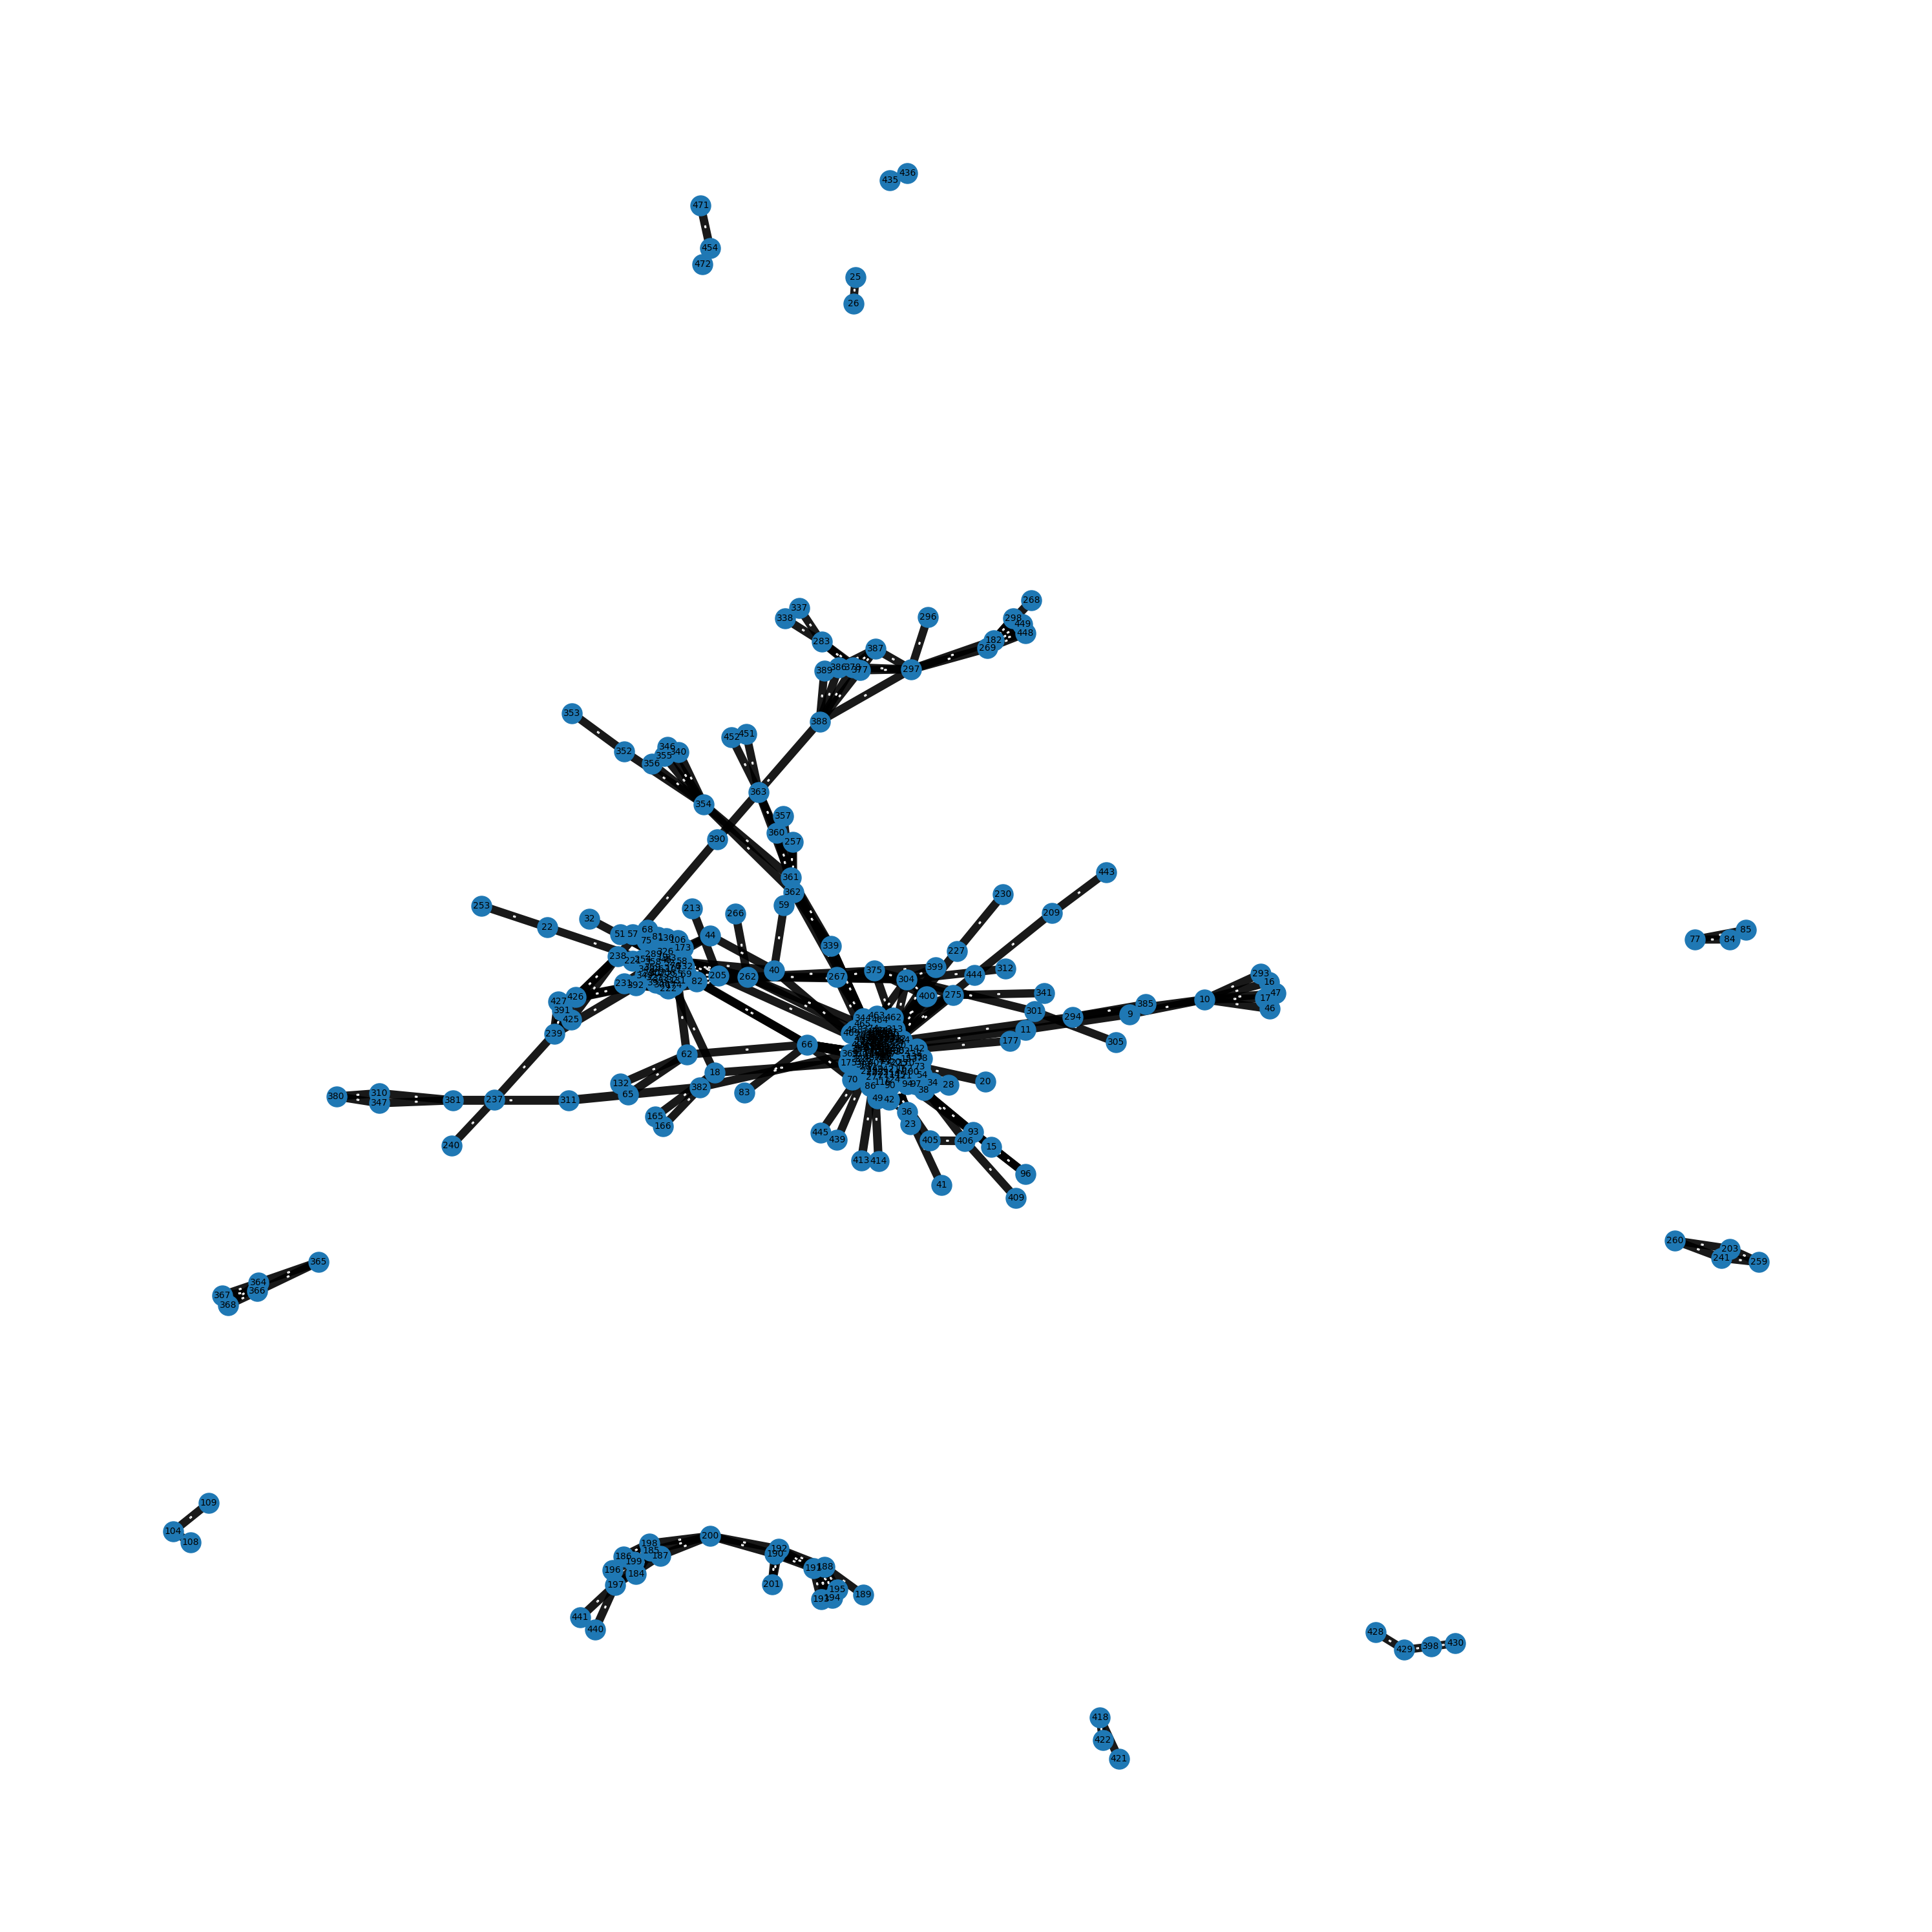

In [24]:
from visualizer import visualize

indexes = [{"id": index} for index in range(len(chunks))]
graph_dict = {"nodes": indexes, "links": links}
# graph_dict

visualize(graph_dict)